In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm
from scipy.stats import chi2_contingency
import warnings
from kmodes.kmodes import KModes
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import gower
import random
import prince
from statistics import mean

In [7]:
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

In [9]:
cmap, cmap1 = cm.get_cmap('Blues'), cm.get_cmap('terrain')

In [10]:
#Изменить пути до файлов
sales = pd.read_parquet("sales.parquet")
shops = pd.read_parquet("shops.parquet")
cities = pd.read_parquet("cities.parquet")

## Структура:
### 1) Разведочный анализ данных - shops, cities
### 2) Обработка данных и кластеризация - shops
### 3) Разведочный анализ данных - sales
### 4) Обработка данных  - sales
### 5) Комбинация shops и sales, итоговая кластеризация

## Решение

### 1) Разведочный анализ данных - shops, cities

#### a) Для начала соединим таблицы shops и cities по city.

In [11]:
print('Уникальных магазинов: ', len(set(shops['shop_id'])))

Уникальных магазинов:  845


In [12]:
shops = shops.merge(cities, left_on='city', right_on='city', how='outer')

##### Добавим признак: возраст магазина к моменту 2148 года, и удалим year_opened. Присвоим None тем объектам в age, для котрый год открытия был отрицательным.

In [13]:
shops['age'] = 2148 - shops['year_opened']
shops.drop('year_opened', inplace=True, axis=1)
shops['age'] = np.where(shops['age']>=2149, None, shops['age'])

In [14]:
shops_new = shops

##### Также три признака с вариантами "да"/"нет", заменим на "да"=1 и "нет"=0

In [15]:
dicty = {'да': 1,'нет': 0} 
shops.is_on_the_road = [ dicty[item] if item is not None else item for item in shops.is_on_the_road] 
shops.is_with_the_well = [dicty[item] if item is not None else item for item in shops.is_with_the_well] 
shops.is_with_additional_services = [dicty[item] if item is not None else item for item in shops.is_with_additional_services] 

#### b) Подсчитаем количество пропусков в каждом столбце. Видно, что довольно много недостающих значений, особенно, в типе магазина. 
##### Очевидно, что строки с NA выбрасывать насовсем нельзя, ведь это - уникальные магазины, которые нужно отнести к кластерам. Можно попробовать сделать кластеризацию без них на первоначальном этапе, но потом обязательно стоит попытаться заполнить пробелы или же даже удалить признак, где слишком много пропусков.

In [16]:
shops.isna().sum()

shop_id                          0
neighborhood                     0
city                            57
is_on_the_road                   7
is_with_the_well                60
is_with_additional_services     61
shop_type                      132
location                        57
age                             63
dtype: int64

#### c) Посмотрим на статистику категориальных переменных в shops

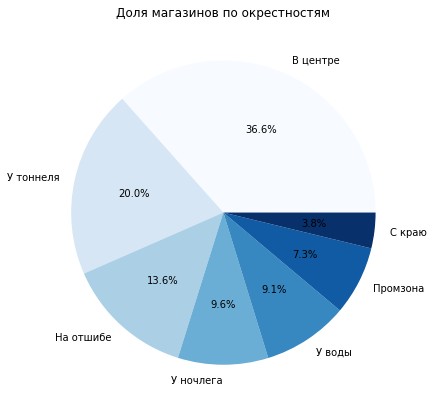

In [17]:
shops['neighborhood'].value_counts().plot.pie(title = 'Доля магазинов по окрестностям', colormap=cmap, figsize=(7,7), autopct='%1.1f%%')
plt.ylabel('')
plt.show()

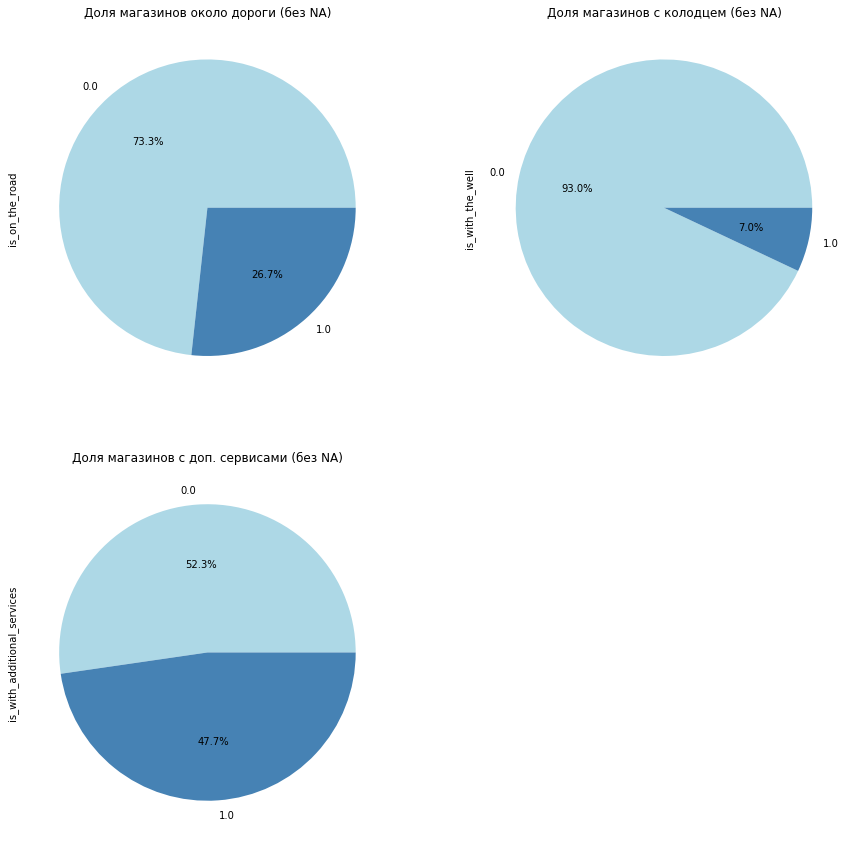

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,15)
titles = ['Доля магазинов около дороги (без NA)', 'Доля магазинов с колодцем (без NA)', 'Доля магазинов с доп. сервисами (без NA)']
for i, name in enumerate(['is_on_the_road', 'is_with_the_well', 'is_with_additional_services']):
    shops[name].value_counts().plot.pie(ax = axes[i//2, i%2], title = titles[i], colors = ['lightblue', 'steelblue'], autopct='%1.1f%%')

fig.delaxes(axes[1,1])

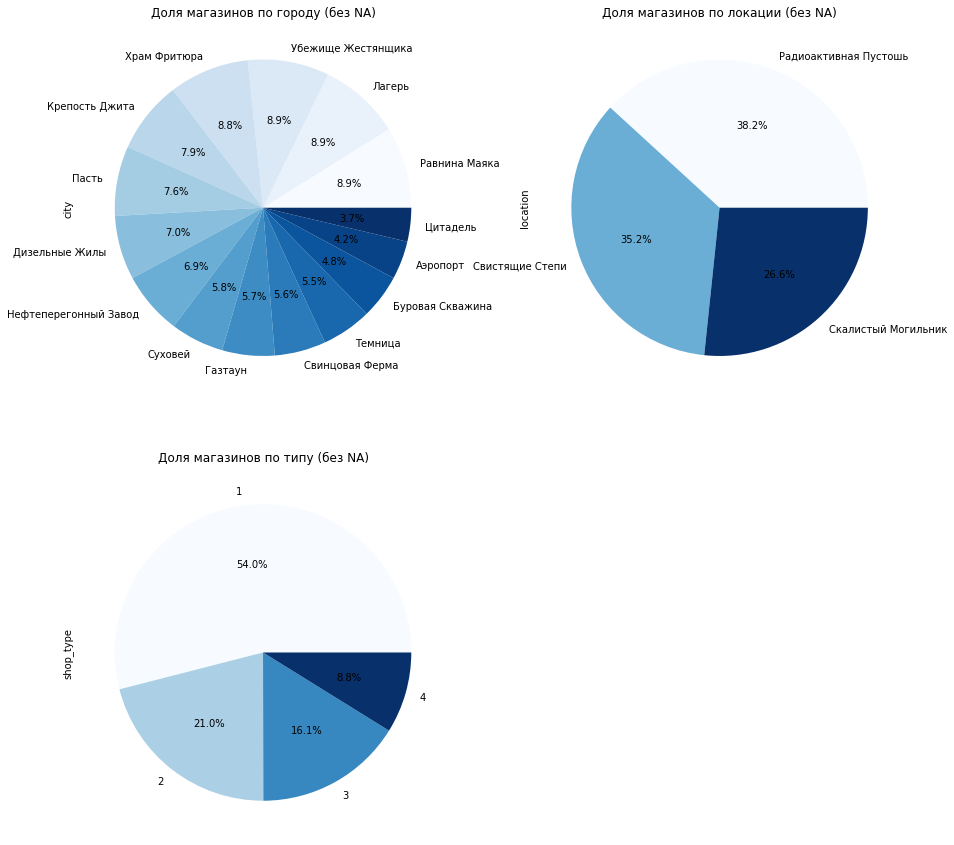

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,15)
titles = ['Доля магазинов по городу (без NA)', 'Доля магазинов по локации (без NA)', 'Доля магазинов по типу (без NA)']
for i, name in enumerate(['city', 'location', 'shop_type']):
    shops[name].value_counts().plot.pie(ax = axes[i//2, i%2], title = titles[i], colormap = cmap, autopct='%1.1f%%')

fig.delaxes(axes[1,1])

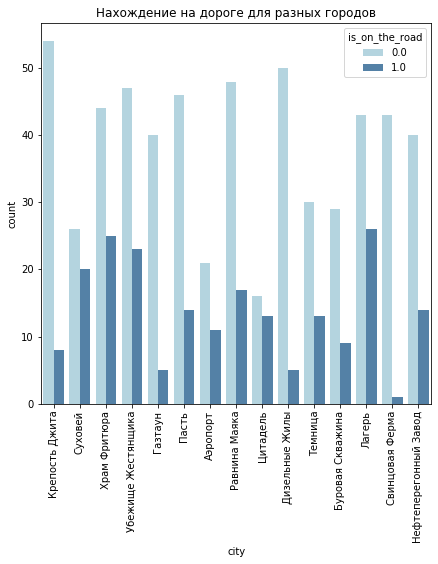

In [20]:
plt.figure(figsize=(7,7))
g = sns.countplot(x="city", hue='is_on_the_road', data=shops, palette=['lightblue', 'steelblue'])
plt.xticks(rotation=90)
plt.title('Нахождение на дороге для разных городов')
plt.show()

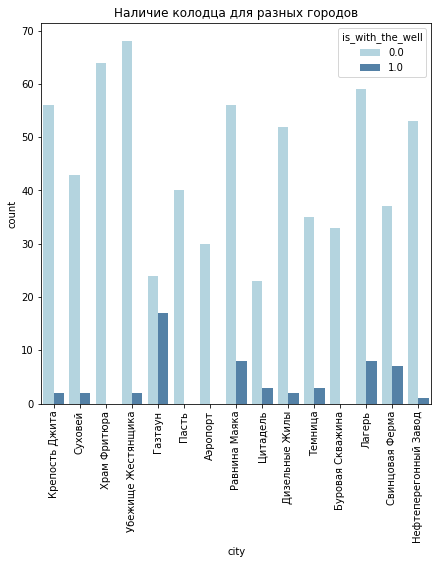

In [21]:
plt.figure(figsize=(7,7))
g = sns.countplot(x="city", hue='is_with_the_well', data=shops, palette=['lightblue', 'steelblue'])
plt.xticks(rotation=90)
plt.title('Наличие колодца для разных городов')
plt.show()

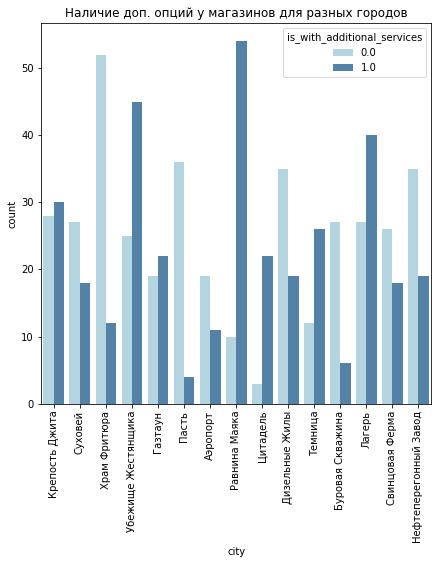

In [22]:
plt.figure(figsize=(7,7))
g = sns.countplot(x="city", hue='is_with_additional_services', data=shops, palette=['lightblue', 'steelblue'])
plt.xticks(rotation=90)
plt.title('Наличие доп. опций у магазинов для разных городов')
plt.show()

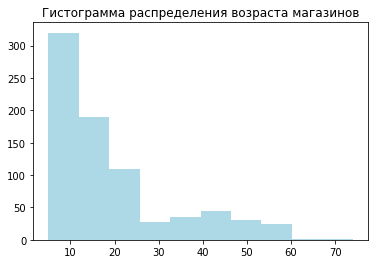

In [23]:
plt.hist(shops['age'].dropna(), color='lightblue')
plt.title('Гистограмма распределения возраста магазинов')
plt.show()

### 2) Обработка данных и кластеризация - shops

#### a) Обработка пропусков - данные без пропусков

##### Пропуски можно обрабатывать по-разному. Вариант с их заполнением, например, модой рассматривать не хочется. Из выше приведенных диаграмм заметно, что часто для признаков доминирует какое-либо одно значение, соответственно, оно и будет вставлено в пропуски. Так поступать некорректно в данной ситуации, поэтому пойдем по другому пути.

In [24]:
shops_clear2 = shops.dropna()
shops_clear = shops.dropna().iloc[:,1:]
shops_clear1 = shops_clear.iloc[:, :7]

In [25]:
print('После отбрасывания строк с None осталось: ', shops_clear.shape[0], ' объекта.')

После отбрасывания строк с None осталось:  619  объекта.


#### b) Кластеризация shops без пропусков

##### После отбрасывания всех пропусков заметно, что в принцепи осталось много магазинов. Можно попробовать кластеризовать их, чтобы создалась общая примерная картина по кластерам. Далее для объектов с пропусками искать ближайших к ним соседей и вместо пропусков вставлять наиболее вероятные значения в конкретных кластерах. 

##### Проверим, существует ли взаимосвязь между категориальными столбцами, чтобы в дальнейшем было проще класетризовать.  Используем тест Пирсона хи-квадрат.

In [26]:
def chi2_testing(shops_clear1):
    
    print('На 95% уровне значимости гипотеза о независимости отвергается для признаков:\n')
    ncol = shops_clear1.shape[1]
    for j in range(0, ncol):
        for i in range(j, ncol):
            if j != i:
                obs = pd.crosstab(shops_clear1.iloc[:, j], shops_clear1.iloc[:, i],  margins = False)
                chi2, p, dof, ex = chi2_contingency(obs, correction = True)
                if p <= 0.05:
                    print(shops_clear1.columns[j], ' и ', shops_clear1.columns[i], ' отвергается. P-value = ', p)

In [27]:
chi2_testing(shops_clear1)

На 95% уровне значимости гипотеза о независимости отвергается для признаков:

neighborhood  и  city  отвергается. P-value =  7.60900641408983e-37
neighborhood  и  is_on_the_road  отвергается. P-value =  7.163069177360021e-49
neighborhood  и  is_with_the_well  отвергается. P-value =  0.002786827025851989
neighborhood  и  is_with_additional_services  отвергается. P-value =  5.3609750626468375e-08
neighborhood  и  shop_type  отвергается. P-value =  2.691871331952006e-13
neighborhood  и  location  отвергается. P-value =  1.6706779863732994e-09
city  и  is_on_the_road  отвергается. P-value =  4.45171531713938e-08
city  и  is_with_the_well  отвергается. P-value =  1.2672975377503645e-14
city  и  is_with_additional_services  отвергается. P-value =  1.00570796504192e-16
city  и  shop_type  отвергается. P-value =  5.295258502850817e-63
city  и  location  отвергается. P-value =  4.771078098009073e-243
is_on_the_road  и  shop_type  отвергается. P-value =  0.001998188888440095
is_with_the_well  и 

##### Многие признаки довольно сильно связаны, данная связь должна прослеживаться и в кластерах.

##### Для смеси категориальных и непрерывных признаков в данных можно использовать кластеризацию с метрикой Гауэра. 
##### Первый вариант реализации: k-medoids - алгоритм PAM, он сочетается с метрикой Гауэра и подходит для наших типов данных. Далее строим график силуэта и по нему опрделеям возможное количество кластеров. (gower2_pma.R).
##### Также попробуем иерархическую кластеризацию с методом полной связи. Будет использоваться расстояние Гауэра. (gower2_hier.R). Чтобы выбрать кластеры  объектов - магазины будут визуализированы.

##### Использование R обусловлено в данном случае тем, что там проще кластеризовать датасеты, используя PAM алгоритм. В нашем случае - это важный плюс.

##### Загрузим датасет с получившимися кластерами обратно и попробуем посмотреть на различия между данными в кластерах.

In [28]:
shops_clear2.to_csv('shops_clear.csv', encoding='cp1251')

In [34]:
shops_pma = pd.read_csv('shops_clear_clustered_pma.csv', encoding='CP1251')
shops_hier = pd.read_csv('shops_clear_clustered_hierarchi.csv', encoding='CP1251')

In [35]:
def clustered_shops_info(shops_gower1, num):
    for cl in range(1,num+1):
        print('*******')
        print('Окрестность: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['neighborhood'].value_counts().index[0])
        print('Город: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['city'].value_counts().index[0])
        print('Локация: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['location'].value_counts().index[0])
        print('Нахождение у дороги: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['is_on_the_road'].value_counts().index[0])
        print('Наличие колодца: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['is_with_the_well'].value_counts().index[0])
        print('Наличие дополнительных сервисов: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['is_with_additional_services'].value_counts().index[0])
        print('Медианный срок существования: ', shops_gower1[shops_gower1['clusters_'+str(num)]==cl]['age'].median())

In [36]:
clustered_shops_info(shops_pma, 14)

*******
Окрестность:  В центре
Город:  Крепость Джита
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  1
Медианный срок существования:  21.0
*******
Окрестность:  На отшибе
Город:  Суховей
Локация:  Скалистый Могильник
Нахождение у дороги:  1
Наличие колодца:  0
Наличие дополнительных сервисов:  1
Медианный срок существования:  11.0
*******
Окрестность:  У тоннеля
Город:  Храм Фритюра
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  22.0
*******
Окрестность:  В центре
Город:  Суховей
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  9.0
*******
Окрестность:  На отшибе
Город:  Убежище Жестянщика
Локация:  Свистящие Степи
Нахождение у дороги:  1
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  35.0
*******
Окрест

In [37]:
clustered_shops_info(shops_hier, 10)

*******
Окрестность:  В центре
Город:  Крепость Джита
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  1
Медианный срок существования:  21.0
*******
Окрестность:  У воды
Город:  Лагерь
Локация:  Радиоактивная Пустошь
Нахождение у дороги:  1
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  7.0
*******
Окрестность:  У воды
Город:  Лагерь
Локация:  Радиоактивная Пустошь
Нахождение у дороги:  1
Наличие колодца:  0
Наличие дополнительных сервисов:  1
Медианный срок существования:  10.5
*******
Окрестность:  В центре
Город:  Храм Фритюра
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  23.5
*******
Окрестность:  У тоннеля
Город:  Суховей
Локация:  Скалистый Могильник
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  9.0
*******
Окрестность:  На о

#### c) Присваивание пропускам значений вместо NAN наиболее вероятных значений в их кластере.

##### Для каждого магазина с пропусками найдем ближайшего соседа по метрике Гауэра и присвоим кластер соседа. Будем использовать результаты PMA кластеризации на 14 кластеров, так как на графике в gower2_pma.R видно, что данное разделение неплохо подходит для разделеня объектов, оно лучше, чем различное иерархическое разбиение на кластеры в скрипте gower2_hier.R, и обуслаливается хорошим показателем метрики средней ширины силуэта. 
##### В файле в  gower2_pma.R при визуализации, конечно, отчетливо видны три кластера. Однако, для такого числа объектов не совсем целесообразно так разбивать данные, ведь будут потеряны их внутренние отличия и характеристики, поэтому в каждом из трех облаков происходит еще разбиение на подгруппы.

In [38]:
characteristics_names = ['neighborhood', 'city', 'is_on_the_road', 'is_with_the_well', 'is_with_additional_services', 'shop_type', 'location', 'age']
shops_withna = set(shops['shop_id']) - set(shops_clear2['shop_id'])

In [39]:
def find_clusters_fornas(shops_withna, shops, shops_pma):
    clusters_dict = dict()
    for shop in shops_withna:
        df = shops[shops['shop_id']==shop].iloc[:,1:]
        na_columns = df.columns[df.isna().any()].tolist()
        df.dropna(axis=1, inplace=True)

        df_clustered = shops_pma.iloc[:,3:11].drop(na_columns, axis=1)
        df_for_gower = pd.concat([df, df_clustered])
        gower_matr = gower.gower_matrix(df_for_gower)[0]
        gower_dist = gower_matr[1:].tolist()  
        indices = [i for i, x in enumerate(gower_dist) if x == min(gower_dist)]

        cluster = shops_pma.iloc[indices][['clusters_14']].value_counts().index[0][0]
        clusters_dict[shop] = cluster
    return clusters_dict

In [40]:
clusters_dict = find_clusters_fornas(shops_withna, shops, shops_pma)

In [41]:
def make_cluster_characteristics(clusters_dict, shops_pma):
    
    cluster_characteristics_dict = dict()
    for i in set(clusters_dict.values()):
        sh = shops_pma[shops_pma['clusters_14']==i].iloc[:,3:10].mode(axis=0).values.tolist()[0]
        sh.append(shops_pma[shops_pma['clusters_14']==i].iloc[:,11].median())
        cluster_characteristics_dict[i] = sh
        
    return cluster_characteristics_dict

In [42]:
cluster_characteristics_dict = make_cluster_characteristics(clusters_dict, shops_pma)

##### Заполняем пропуски характерными данными для кластера

In [43]:
def fillna_with_top_clusters(clusters_dict, cluster_characteristics_dict, shops_new):
    df_new = pd.DataFrame()
    for shop, cluster in clusters_dict.items():
        characteristics = cluster_characteristics_dict[cluster]
        t = shops_new[shops_new['shop_id'] == shop]
        charac = t.columns[t.isna().any()].tolist()
        for j in charac:
            place = characteristics_names.index(j)
            t.iloc[0, place+1] = characteristics[place]
        t['clusters_14'] = cluster
        df_new = pd.concat([df_new, t])
    return df_new

In [44]:
df_nas_filled = fillna_with_top_clusters(clusters_dict, cluster_characteristics_dict, shops_new)

##### Передадим теперь уже все данные по объектам shops в shops_cleared_new.R, там построим sctter plot, чтобы понять, каким образом присоединились к кластерам объекты с заполненными пропусками. 

In [45]:
shops_cleared = pd.concat([df_nas_filled, shops_pma])

##### Итоговый файл направляем в shops_cleared_new.R для визуализации кластеров

In [46]:
shops_cleared.iloc[:,:10].to_csv('shops_cleared_new.csv', encoding='cp1251')

### 3) Разведочный анализ данных - sales

#### a) Общие характеристики данных

In [47]:
shops_unique = set(sales['shop_id'])

In [48]:
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [49]:
print('Уникальных магазинов: ', len(set(sales['shop_id'])), '. Все магазины встечаются в данной таблице.')

Уникальных магазинов:  845 . Все магазины встечаются в данной таблице.


In [50]:
print('Пропусков в данных нет')
sales.isna().sum()

Пропусков в данных нет


date                  0
shop_id               0
owner                 0
number_of_counters    0
goods_type            0
total_items_sold      0
dtype: int64

In [51]:
print('Уникальные владельцы магазинов: ')
print(set(sales['owner']))
owners_unique = set(sales['owner'])

Уникальные владельцы магазинов: 
{'Стервятники', 'Последователи Апокалипсиса', 'Бомбисты', 'Воины полураспада', 'Рейдеры'}


In [52]:
print('Возможное количество работающих прилавков: ')
print(set(sales['number_of_counters']))

Возможное количество работающих прилавков: 
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


In [53]:
print('Возможные типы товаров: ')
print(set(sales['goods_type']))

Возможные типы товаров: 
{'Патроны', 'Ядер-Кола', 'Хлам', 'Оружие', 'Медпрепараты и еда', 'Солярка', 'Броня и одежда', 'Бензак', 'Съедобный хлам', 'Модификации тачки', 'Жидкости для тачки'}


#### b) Создание новых признаков для магазинов

In [54]:
sales['month'] = sales['date'].dt.month
sales['quarter'] = sales['date'].dt.quarter
sales['weekday'] = sales['date'].dt.weekday
sales['year'] = sales['date'].dt.year
sales['month_name'] = sales['date'].dt.strftime("%B")

In [55]:
# Количество типа товара проданного на одного продавца/прилавок
sales['avg_items_sold'] = sales['total_items_sold'] / sales['number_of_counters']

### 4) Обработка данных  - sales

#### a) Формирование нового датафрейма для shops с новыми признаками

###### Добавление признаков о владельцах магазинов (1 - является владельцем, 0 -  не является владельцем)

In [56]:
def create_shop_owners(shops_unique, owners_unique, sales):    
    shop_owners = pd.DataFrame(index = shops_unique, columns=owners_unique)
    for i, shop in enumerate(shops_unique):
        ow = list(set(sales[sales['shop_id']==shop]['owner']))
        shop_owners.loc[i,ow] = 1
    shop_owners.fillna(0, inplace=True)
    return shop_owners

In [57]:
shop_owners = create_shop_owners(shops_unique, owners_unique, sales)

In [58]:
shop_owners.head()

,Стервятники,Последователи Апокалипсиса,Бомбисты,Воины полураспада,Рейдеры
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


##### Можно добавлять признаки о типе товара, который был продан в наибольших количествах каждым магазином, в годы/кварталы/месяцы. Но заметно, что почти для всех магазинов на первом месте по продажам стоит Бензак (какой бы временной разрез ни был взят - годы, кварталы, месяцы). То есть, по такому принципу признаки делить не стоит, ведь они будут одинаковы для магазинов в разных кластерах.

##### Явно надо обратить внимание на Бензак, так как он доминирует для многих магазинов. Создадим признак с месяцами за два года, для которых были самые большие средние продажи Бензака. Сначала для каждого дня продаж Бензака в месяце было посчитано, сколько в среднем продаж приходится на прилавок/продавца. Затем взята медиана этого показателя за месяц (в 2146 и 2147 годах). Выделен месяц с топом по данному показателю.

In [59]:
def create_benzac_avg_sales(shops_unique, sales):
    benzac_list = []
    for i, shop in enumerate(shops_unique):

        t = sales[sales['shop_id']==shop]
        t = t[t['goods_type']=='Бензак']
        t = t[['month_name', 'avg_items_sold']].groupby(['month_name']).agg('median')
        t.sort_values('avg_items_sold', inplace=True, ascending=False)

        benzac_list.append(t.index[0])
    return benzac_list

In [60]:
benzac_list = create_benzac_avg_sales(shops_unique, sales)

In [61]:
#добавляем новый признак в датафрейм
shop_owners['avg_benzac_month'] = benzac_list

In [62]:
shop_owners['avg_benzac_month'].value_counts()

July         241
August       203
December     160
June          75
November      65
October       49
September     25
January       10
May            6
February       5
March          3
April          3
Name: avg_benzac_month, dtype: int64

##### Добавляем еще один признак для Бензака. Заметно, что в среднем большинство медианных продаж этого продукта приходится на среду (наша нумерация начинается с 0, поэтому среда - это 2). 

In [63]:
def benzac_weekdays(shops_unique, sales):
    benzac_weekdays = []
    benzac_median_weekdays = []
    for sh in shops_unique:
        t = sales[sales['shop_id']==sh]
        t = t[t['goods_type']=='Бензак']
        t = t[['weekday', 'total_items_sold']].groupby(['weekday']).agg('median')
        t.sort_values('total_items_sold', inplace=True, ascending=False)
        benzac_weekdays.append(t.index[0])
        
        benzac_median_weekdays.append(t[t.index==2].iloc[0,0])
        
    return benzac_weekdays, benzac_median_weekdays

In [64]:
benzac_weekdays, benzac_median_weekdays = benzac_weekdays(shops_unique, sales)

In [65]:
#Чаще всего максимальное среднее колво проданного Бензака приходится на среду
pd.Series(benzac_weekdays).value_counts()

2    586
3    205
4     50
1      2
6      1
0      1
dtype: int64

##### Раз рассматриваемый показатель зачастую достигает пика в среду, то добавим количественный признак, показывающий медианное количество проданного Бензака в среды для каждого магазина. 

In [66]:
#добавляем новый признак в датафрейм
shop_owners['median_benzac_wednesday'] = benzac_median_weekdays

##### Также добавим признак, показывающий долю продаж Бензака в общем объеме продаж. Данный показатель не столь сильно различается для каждого магазина для двух лет, поэтому делать два отдельных признака для двух лет бессмысленно. Сделаем один признак, усреднив доли за два года.

In [67]:
def create_benzac_fraction_mean(shops_unique, sales): 
    
    benz_fraction_mean = []
    for sh in shops_unique:
        t = sales[sales['shop_id']==sh]
        z = t[['year', 'total_items_sold']].groupby(['year']).agg('sum')

        t = t[t['goods_type']=='Бензак']
        t = t[['year', 'total_items_sold']].groupby(['year']).agg('sum')
        benz_mean = mean([t.iloc[0,0]/z.iloc[0,0], t.iloc[1,0]/z.iloc[1,0]])
        benz_fraction_mean.append(benz_mean)
    return benz_fraction_mean

In [68]:
benz_fraction_mean = create_benzac_fraction_mean(shops_unique, sales)

In [69]:
#добавляем новый признак в датафрейм
shop_owners['benzac_fraction_mean'] = benz_fraction_mean

##### Перейдем к добавлению признаков, касающийхся других типов продуктов. Посмотрим, насколько разнообразен ассортимент продуктов для магазинов. Добавим признак, показывающий ассортимент: богатый ассортимент (9-11 разных типов), средний ассортимент (6-8), скудный - остальное.

In [70]:
def various_goods_types(shops_unique, sales):
    goods_types_list = []

    for sh in shops_unique:   
        t = sales[sales['shop_id']==sh] 
        t = t[['goods_type', 'total_items_sold']].groupby(['goods_type']).agg('sum')
        types_num = len(list(t.index))
        if types_num >= 9 and types_num<=11:
            goods_types_list.append('Богатый')
        elif types_num >= 6 and types_num<=8:
            goods_types_list.append('Средний')
        elif types_num < 6:
            goods_types_list.append('Скудный')
    return goods_types_list

In [71]:
goods_types_list = various_goods_types(shops_unique, sales)

In [72]:
#добавляем новый признак в датафрейм
shop_owners['various_goods_types'] = goods_types_list

In [73]:
shop_owners['various_goods_types'].value_counts()

Богатый    704
Средний     72
Скудный     69
Name: various_goods_types, dtype: int64

##### Рассмотрим товары для каждого магазина, занимающие вторую и третью строчку по суммарному количеству продаж. Для каждого из них посчитаем медианное количество продаж в день и добавим два новых количественных признака в датафрейм. 

In [74]:
def create_goods_places_medians(shops_unique, sales):
    second_place_goods, third_pace_goods = [], []
    for sh in shops_unique:   
        t = sales[sales['shop_id']==sh] 
        goods = t[['goods_type', 'total_items_sold']].groupby(['goods_type']).agg('sum')
        types_num = len(list(goods.index))
        if types_num >= 3:
            sp = t[t['goods_type']==goods.index[1]]['total_items_sold'].median()
            tp = t[t['goods_type']==goods.index[2]]['total_items_sold'].median()
            
        elif types_num == 2:
            sp = t[t['goods_type']==goods.index[1]]['total_items_sold'].median()
            tp = 0.0           
        else:
            sp = 0.0
            tp = 0.0 
        second_place_goods.append(sp)
        third_pace_goods.append(tp)
    return second_place_goods, third_pace_goods

In [75]:
second_place_goods, third_place_goods = create_goods_places_medians(shops_unique, sales)

In [76]:
#добавляем новые признаки в датафрейм
shop_owners['second_pl_goods_dailymedian'] = second_place_goods
shop_owners['third_pl_goods_dailymedian'] = third_place_goods

In [77]:
shop_owners = shop_owners.reset_index()

In [78]:
shop_owners.rename(columns={'index':'shop_id'}, inplace=True)

In [79]:
shop_owners.head()

,shop_id,Стервятники,Последователи Апокалипсиса,Бомбисты,Воины полураспада,Рейдеры,avg_benzac_month,median_benzac_wednesday,benzac_fraction_mean,various_goods_types,second_pl_goods_dailymedian,third_pl_goods_dailymedian
0,0,0,0,0,0,1,July,18057.0,0.999782,Скудный,2.0,17.5
1,1,0,0,0,0,1,July,14732.0,0.852100,Средний,3.0,20.0
2,2,0,0,0,0,1,December,12762.0,0.779189,Богатый,18.0,15.0
3,3,0,0,0,0,1,December,34748.5,0.903570,Богатый,2.0,21.0
4,4,0,0,0,0,1,December,33797.0,0.833381,Богатый,16.0,20.0


### 5) Комбинация shops и sales, итоговая кластеризация

In [80]:
shops_cleared1 = shops_cleared.iloc[:,:10]
shops_final = shops_cleared1.merge(shop_owners, left_on='shop_id', right_on='shop_id')

In [81]:
shops_final.to_csv('shops_final.csv', encoding='cp1251')

##### Далее передаем датафрейм в R в gower2_pma_shopsfinal.R и там кластеризуем магазины уже по всем признакам. Выделены 17 кластеров, результаты записаны в файл shops_final_new.csv. Прочтем его сюда и посмотрим на характеристики кластеров.

In [82]:
num1 = 17

In [83]:
shops_final_new = pd.read_csv('shops_final_new.csv', encoding='cp1251')

In [84]:
shops_final_new = shops_final_new.iloc[:, 2:]

In [85]:
shops_final_new.drop('clusters_14', axis=1, inplace=True)

In [86]:
def clustered_shops_description(df, num1):
    for cl in range(1,num1+1):
        df1 = df[df['cluster_id']==cl]
        print('*******')
        print('Кластер: ', cl)
        print('Окрестность: ', df1['neighborhood'].value_counts().index[0])
        print('Город: ', df1['city'].value_counts().index[0])
        print('Локация: ', df1['location'].value_counts().index[0])
        print('Нахождение у дороги: ', df1['is_on_the_road'].value_counts().index[0])
        print('Наличие колодца: ', df1['is_with_the_well'].value_counts().index[0])
        print('Наличие дополнительных сервисов: ', df1['is_with_additional_services'].value_counts().index[0])
        print('Медианный срок существования: ', df1['age'].median())
        print('Стервятники: ')
        print(df1['Стервятники'].value_counts())
        print('Бомбисты: ')
        print(df1['Бомбисты'].value_counts())
        print('Рейдеры: ')
        print(df1['Рейдеры'].value_counts())
        print('Воины.полураспада: ')
        print(df1['Воины.полураспада'].value_counts())
        print('Последователи.Апокалипсиса: ')
        print(df1['Последователи.Апокалипсиса'].value_counts())
        print('Месяцы, в которых больше всего продаж Бензака на человека/лавку: ')
        print(df1['avg_benzac_month'].value_counts())
        print('Медианное кол-во проданного Бензака в среду для каждого магазина: ', df1['median_benzac_wednesday'].median())
        print('Доля Бензака в общем объеме продаж: ', df1['benzac_fraction_mean'].median())
        print('Разннобразие ассортимента подуктов в магазинах: ', df1['various_goods_types'].value_counts())
        print('Медианное кол-во продаж второго по популярности товара в день: ', df1['second_pl_goods_dailymedian'].median())
        print('Медианное кол-во продаж третьего по популярности товара в день: ', df1['third_pl_goods_dailymedian'].median())

In [87]:
clustered_shops_description(shops_final_new, num1)

*******
Кластер:  1
Окрестность:  В центре
Город:  Буровая Скважина
Локация:  Свистящие Степи
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  15.0
Стервятники: 
0    73
1     5
Name: Стервятники, dtype: int64
Бомбисты: 
0    78
Name: Бомбисты, dtype: int64
Рейдеры: 
1    71
0     7
Name: Рейдеры, dtype: int64
Воины.полураспада: 
0    73
1     5
Name: Воины.полураспада, dtype: int64
Последователи.Апокалипсиса: 
0    77
1     1
Name: Последователи.Апокалипсиса, dtype: int64
Месяцы, в которых больше всего продаж Бензака на человека/лавку: 
July         37
August       14
November     13
December     10
October       3
September     1
Name: avg_benzac_month, dtype: int64
Медианное кол-во проданного Бензака в среду для каждого магазина:  29183.75
Доля Бензака в общем объеме продаж:  0.8157269511554555
Разннобразие ассортимента подуктов в магазинах:  Богатый    67
Средний     8
Скудный     3
Name: various_goods_types, dtype: int6

Кластер:  13
Окрестность:  У ночлега
Город:  Свинцовая Ферма
Локация:  Радиоактивная Пустошь
Нахождение у дороги:  0
Наличие колодца:  0
Наличие дополнительных сервисов:  0
Медианный срок существования:  9.0
Стервятники: 
0    40
Name: Стервятники, dtype: int64
Бомбисты: 
0    40
Name: Бомбисты, dtype: int64
Рейдеры: 
1    40
Name: Рейдеры, dtype: int64
Воины.полураспада: 
0    38
1     2
Name: Воины.полураспада, dtype: int64
Последователи.Апокалипсиса: 
0    40
Name: Последователи.Апокалипсиса, dtype: int64
Месяцы, в которых больше всего продаж Бензака на человека/лавку: 
December     14
November     11
October       8
September     3
July          2
June          1
August        1
Name: avg_benzac_month, dtype: int64
Медианное кол-во проданного Бензака в среду для каждого магазина:  24328.5
Доля Бензака в общем объеме продаж:  0.8606050038814744
Разннобразие ассортимента подуктов в магазинах:  Скудный    33
Средний     4
Богатый     3
Name: various_goods_types, dtype: int64
Медианное

##### Далее сравним внутрикластерное расстояние для двух вариантов: если использовать итоговые получившиеся кластеры и если взять кластеризацию по городам. Для каждого кластера будем считать средний внутрикластерный квадрат расстояния, затем возьмем их сумму. По этой метрике и сравним.

In [88]:
def dist_in_clusters(data, num1):
    data1 = data.drop('shop_id', axis=1)
    mean_dist_list = []
    for cl in range(1, num1+1):
        df = data1[data1['cluster_id']==cl]
        df.drop('cluster_id', axis=1, inplace=True)
        dist_gower = gower.gower_matrix(df)
        mean_dist_list.append((sum(sum(dist_gower**2))/2.0)/len(dist_gower))
    return sum(mean_dist_list)

In [89]:
def dist_in_clusters_old(data):
    data1 = data.drop('shop_id', axis=1)
    data1 = data1.drop('cluster_id', axis=1)
    mean_dist_list = []
    for cl in set(data1['city']):
        df = data1[data1['city']==cl]
        df.drop('city', axis=1, inplace=True)
        dist_gower = gower.gower_matrix(df)
        mean_dist_list.append((sum(sum(dist_gower**2))/2.0)/len(dist_gower))
    return sum(mean_dist_list)

In [90]:
mean_dist_new = dist_in_clusters(shops_final_new, num1)

In [91]:
mean_dist_old = dist_in_clusters_old(shops_final_new)

In [92]:
print('Метрика до: ', round(mean_dist_old))
print('Метрика после: ', round(mean_dist_new))

Метрика до:  33.0
Метрика после:  25.0
